# Machine learning Wandelaars


## Packages installeren

In [1]:
import pickle
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json

#Kmeans voor preprocessing
from sklearn.cluster import KMeans

# classifiers & testing
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

## Functie definities

In [2]:
def sliding_window(DataSet):
    """
    Maak van een dataset een patroon via het sliding window principe:
    
    Voor elke array in de data set:
      - bepaal de lengte van de array. Het aantal windows is gelijk aan de lengte van de array -2
        (anders loopt de window over het einde van de array met fout melding als gevolg)
      - vul een window van 3x3 en maak hier een vector van (sla het window plat met hstack).
      - schrijf deze vector weg in de nieuwe dataset
    Schrijf elke nieuwe array weg in de nieuwe dataset


    In: Dataset opgebouwd uit een array van arrays

    Out: Dataset bestaande uit een array met vectoren.
    """

    DataOut=[]
    for InArray in DataSet:
        lengteArray = InArray.shape[0]
        for regelNr in range(lengteArray-2):
            window = (np.hstack((InArray[regelNr],InArray[regelNr+1],InArray[regelNr+2])).tolist())
            DataOut.append(window)
    return np.array(DataOut)

def discretiminator(Dataset,noClusters,Labels):
    """
    Maak van een dataset, aantal clusters en labels een matrix in de vorm van
    lengte dataset x aantal clusters.
    
    Tel vervolgens hoe vaak een aantal clusters per rij voorkomt door 1 op te tellen 
    bij de index die overeenkomt met het cluster (dus als het label de waarde 0 heeft 
    moet er 1 opgeteld worden bij kolom 0. Dus het cluster zelf bepaald bij 
    welke kolom er een wordt opgeteld. Als de lengte van een array uit X_train afgelopen 
    is wordt een volgende rij gemaakt

    In: 
    - Dataset opgebouwd uit een array van arrays. Voor deze case is dit X_train
    - noClusters clusters die in de KMeans is gebruikt en bepaald aantal kolommen van de DataOut
    - Labels bepaald met KMeans

    Out: Dataset bestaande uit een array met vectoren.
    """

    DataOut=np.zeros((len(Dataset),noClusters))
    teller = 0
    for idx,array in enumerate(Dataset):
        for i in range(array.shape[0]-2):
            DataOut[idx,Labels[teller]]+=1
            teller+=1
    return(DataOut)

## Data inlezen
Data inlezen. Trainingsdata in data (X) en klasse/label (y). Data welke voorspelt moet worden in X_pred.

En kijken waar het uit bestaat en hoe het is opgebouwd.

In [3]:
X, y = pickle.load(open("train_X_y.p", "rb"))
X_pred = pickle.load(open('test_X.p', 'rb'))

Lengte?

In [4]:
len(X), len(y), len(X_pred)

(1857, 1857, 626)

Welke klassen/labels zijn er?

In [5]:
np.unique(y)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

Hoe vaak komen deze klassen/labels voor?

In [6]:
np.bincount(y)

array([ 63,  48,  15,  90,  13,  60,  46,  43, 100,  39,  70,  60,  83,
       149,  45,  21, 276, 258,  12, 207,  38, 121], dtype=int64)

Wat is het type van de data?

In [7]:
type(X)

list

Hoe zien de elementen van de lijst er uit?

In [25]:
print(type(X[-1]))
print(type(X[-1][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Dus een lijst met Arrays met Arrays. Opbouw van de eerste array:

In [26]:
X[0]

array([[ -0.081722,   9.9565  ,  -0.23155 ],
       [  1.2667  ,   8.6898  ,  -0.65378 ],
       [  0.38137 ,   9.7249  ,  -0.88532 ],
       [ -0.65378 ,  10.379   ,  -1.076   ],
       [ -0.27241 ,   8.8124  ,   0.23155 ],
       [  0.65378 ,   7.0145  ,   0.92618 ],
       [  0.61292 ,   6.8238  ,   0.19068 ],
       [ -0.14982 ,   7.5048  ,  -0.34051 ],
       [ -0.14982 ,   8.0496  ,  -0.081722],
       [  0.42223 ,   8.1177  ,   0.53119 ],
       [  0.27241 ,   8.3084  ,   0.8036  ],
       [ -0.38137 ,   8.7715  ,   0.95342 ],
       [ -0.46309 ,   9.9973  ,   0.8036  ],
       [  0.040861,  11.795   ,   0.8036  ],
       [ -0.29965 ,  12.531   ,   1.9477  ],
       [ -1.5255  ,  12.871   ,   2.7649  ],
       [ -0.61292 ,  14.288   ,   1.6481  ],
       [  0.92618 ,  12.599   ,   0.14982 ],
       [  2.3427  ,   9.6568  ,  -0.29965 ],
       [  4.1406  ,   8.3084  ,  -0.76274 ],
       [  5.598   ,   8.3084  ,  -0.91256 ],
       [  4.4811  ,   9.003   ,  -0.23155 ],
       [  

Train data splitsen in 80% trainen en 20% testen.

De totale lengte van alle arrays bij elkaar opgeteld voor X-Train:

In [27]:
som=0
for item in X:
    som+=item.shape[0]
print(som)

112051


In [28]:
sum([(array.shape[0]-2) for array in X])

108337

Bovenstaande waarde is de lengte van de array die KMeans in moet na uitvoeren van sliding window met een window van 3x3.

### Conclusies over de dataset
Er zijn 22 klasses (0 t/m 21).

Trainingsdata bestaat uit een lijst met arrays met arrays. Deze hebben verschillende lengte, van 45 rijen tot en met 79 rijen, en 3 kolommen.

## Preprocessing traindata en testdata
De dataset is zo niet bruikbaar om te leren. We gaan het sliding window principe toepassen om de individuele waarden om te zetten naar een bewegingspatroon. Ter visualisatie: je zou de punten kunnen zien als punten van een golfbeweging. Alleen is dit niet direct herkenkenbaar aan de punten. Met de sliding window breng je deze beweging in je dataset.

Vervolgens discretiseer je deze beweging via Kmeans (alsof je een analoog signaal discretiseert met een ADC). Zo krijg je per "beweging" hetzelfde aantal metingen (de clusters). Alleen de frequentie van die metingen varieert.

In [9]:
X_sw=sliding_window(X)

In [10]:
X_sw.shape

(108337, 9)

### Omzetten naar clusters via KMeans
We laten KMeans met een aantal clusters (van 10 tot en met 50) draaien en plotten de inertia om een keuze voor het aantal clusters te maken.

In [31]:
#max_K = 50

#distortions =  np.zeros(max_K)
#for K in range(10,max_K):
#    kmeans = KMeans(n_clusters=K+1)
#    kmeans.fit(X_sw)
    
    #distortions[K] = KMeans(n_clusters=K+1).fit(X).inertia_
#    distortions[K] = kmeans.inertia_

In [32]:
#plt.plot(range(1,max_K+1), distortions)
#plt.ylabel('Distortion')
#plt.xlabel('Number of clusters');

Uit de plot blijkt niet een direct een knik. Een hogere waarde voor k lijkt een beter resultaat op te leveren. Vanwege rekentijd kies ik k=30.

In [8]:
noClusters = 30
km = KMeans(n_clusters=noClusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)

Elke window een label geven en kijken wat het resultaat is.

In [11]:
labels_sw = km.fit_predict(X_sw)

In [13]:
labels_sw

array([8, 8, 8, ..., 0, 0, 0])

In [36]:
labels_sw.shape

(108337,)

In [37]:
np.unique(labels_sw)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

Matrix maken per als rijen de fragmenten uit de trainingsdata (1857 rijen) en als kolommen de clusters. De waarden van de labels komen dus overeen met de kolompositie. Hier kan je gebruik van maken van het optellen van hoe vaak een cluster voorkomt bij een fragment.

Door van hetzelfde opdelingsprincipe gebruik te maken als bij het maken van de sliding window komen de juiste labels bij het juiste fragment terecht. De teller gaat hierdoor van 0 tot en met 108337.

In [14]:
xtc=discretiminator(X,noClusters,labels_sw)

In [15]:
xtc.shape

(1857, 30)

In [17]:
xtc[10:20]

array([[  0.,   2.,   6.,   0.,  17.,   2.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   6.,   6.,   2.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   8.,   0.,   0.,   0.,   0.,   0.,   2.,   9.,   0.,   0.,
          0.,   0.,   1.,   0.,   3.,   4.,   7.,   0.,   0.,   0.,   3.,
          0.,   0.,   0.,   0.,   3.,  16.,   0.,   4.],
       [  0.,   1.,  14.,   0.,   2.,   6.,   0.,   0.,   2.,   0.,   5.,
          0.,   0.,   0.,   0.,   3.,  12.,   8.,   4.,   0.,   0.,   0.,
          0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   5.,   0.,   9.,   4.,   0.,   2.,   3.,   0.,   9.,
          0.,   0.,   2.,   0.,   1.,  20.,   0.,   7.,   0.,   0.,   1.,
          0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   7.,   3.,   0.,   2.,   0.,   0.,   0.,  10.,   0.,   0.,
          0.,   0.,   3.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0., 

In [18]:
y[10:20]

[21.0, 19.0, 17.0, 17.0, 16.0, 19.0, 16.0, 7.0, 15.0, 17.0]

### Preprocessing van de  data waar de ML over moet voorspellen.

In [41]:
X_pred_sw=sliding_window(X_pred)

In [42]:
X_pred_labels = km.predict(X_pred_sw)

In [43]:
X_pred_c=discretiminator(X_pred,noClusters,X_pred_labels)

In [44]:
X_pred_c[:]

array([[  0.,   1.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   7., ...,   0.,   0.,   0.],
       [  0.,   9.,   0., ...,   0.,   0.,   3.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   7.,  13., ...,   5.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,  10.]])

In [45]:
X_pred_c.shape

(626, 30)

## Learning algoritme
We proberen SVM en Naive Bayes als learning algoritme om de voorspelling te doen welke data bij welke wandelaar hoort.

In [46]:
# initialize parameters
c_params = [0.01, 0.03, 0.1, 0.3, 1, 3]
kernel_params = ['linear', 'rbf']
parameters = {'kernel':kernel_params, 'C':c_params}

# perform cross validation grid search
clfSVM = GridSearchCV(SVC(), parameters, cv=5).fit(xtc, y)

In [47]:
clfSVM.best_params_, clfSVM.best_score_

({'C': 0.03, 'kernel': 'linear'}, 0.72374798061389334)

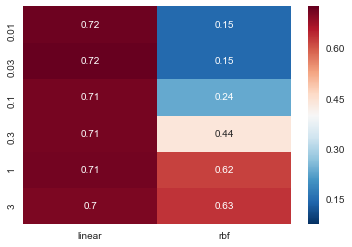

In [48]:
scores = clfSVM.cv_results_['mean_test_score'].reshape(len(c_params), len(kernel_params))
sns.heatmap(scores, center=0.4, yticklabels=c_params, xticklabels=kernel_params, annot=True);

Score SVM op trainingsdata is bij k=30 is 0.72. Bij k=20 was SVM score 0.68. Meer clusters geeft hogere score.

Eens kijken wat Naive Bayes doet. 

In [49]:
# initialize parameters
alpha_params = [0.1, 0.3, 0.5, 0.7, 1.0]

parameters = {'alpha':alpha_params}

# perform cross validation grid search
clfNB = GridSearchCV(MultinomialNB(), parameters, cv=5).fit(xtc,y)

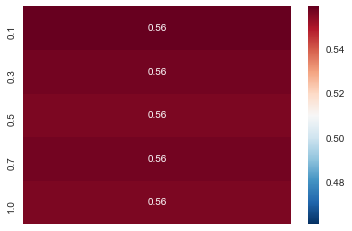

In [50]:
scores = clfNB.cv_results_['mean_test_score'].reshape(len(alpha_params),1)
sns.heatmap(scores, center=0.51, yticklabels=alpha_params, xticklabels='', annot=True);

In [51]:
clfNB.best_params_, clfNB.best_score_

({'alpha': 0.1}, 0.55896607431340872)

Naive Bayes doet het slechter dan SVM. We proberen een neuraal net.

In [52]:
mlp = MLPClassifier(solver='lbfgs', 
                    activation='logistic',
                    momentum=0.2,
                    tol=0.00001)

In [53]:
hiddenunits_params = [(1),(3),(10),(20),(30), (50), (100)]
learningrate_params = [0.01, 0.05, 0.1, 0.5, 1.0] 
parameters = {'hidden_layer_sizes':hiddenunits_params, 'learning_rate_init':learningrate_params}

clfMLP = GridSearchCV(mlp, parameters, cv=3).fit(xtc, y)

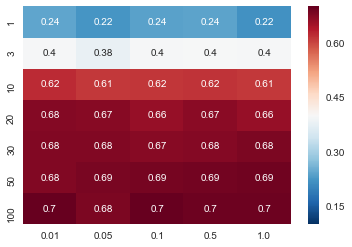

In [54]:
scores = clfMLP.cv_results_['mean_test_score'].reshape(len(hiddenunits_params), len(learningrate_params))
sns.heatmap(scores, center=0.4, yticklabels=hiddenunits_params, xticklabels=learningrate_params, annot=True);

In [55]:
clfMLP.best_params_, clfMLP.best_score_

({'hidden_layer_sizes': 100, 'learning_rate_init': 0.1}, 0.70059235325794289)

Ook de multilayer classifier werkt niet beter als SVM. Als laatste een decision tree.

In [56]:
tree = DecisionTreeClassifier()

In [57]:
criterion_params = ['gini','entropy']
max_features_params = ['auto','sqrt','log2'] 
parameters = {'criterion':criterion_params, 'max_features':max_features_params}

clfTREE = GridSearchCV(tree, parameters, cv=3).fit(xtc, y)

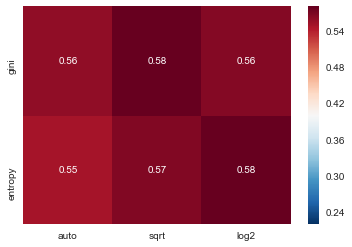

In [58]:
scores = clfTREE.cv_results_['mean_test_score'].reshape(len(criterion_params), len(max_features_params))
sns.heatmap(scores, center=0.4, yticklabels=criterion_params, xticklabels=max_features_params, annot=True);

## De uiteindelijke voorspelling

SVM geeft het beste resultaat. Dus we gebruiken die om de voorspelling te doen. Maar eerst nog even de f1 score hiervan vaststellen.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(xtc, y, test_size=0.2, random_state=0)
y_pred = clfSVM.predict(X_test)
np.unique(y_pred)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  19.,  20.,  21.])

In [60]:
np.array(y_test)[3]

6.0

In [61]:
errors = 1 - f1_score(np.array(y_test), y_pred, average='macro')
errors

c:\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.25297031111117796

In [62]:
errors2 = f1_score(np.array(y_test), y_pred, average='macro')
errors2

c:\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.74702968888882204

In [63]:
y_predSVM = clfSVM.predict(X_pred_c)

In [64]:
y_predSVM

array([ 17.,  17.,  11.,  19.,  17.,  16.,   9.,   5.,  19.,  12.,  13.,
         2.,   3.,   5.,  19.,   4.,  17.,  19.,  16.,  13.,   8.,  19.,
         3.,  21.,  17.,   6.,  13.,  20.,  21.,  13.,  16.,  13.,  10.,
        16.,   1.,   3.,   8.,  21.,  17.,  21.,  16.,  16.,   5.,  21.,
         3.,  11.,  13.,  16.,   5.,  16.,  19.,  13.,   0.,  13.,  19.,
        14.,   8.,   9.,  11.,  17.,  20.,  17.,  21.,  21.,  21.,  16.,
         3.,  10.,  19.,  20.,  13.,   8.,   2.,  19.,  19.,  12.,  21.,
         3.,  16.,  19.,  16.,  16.,  16.,  17.,  11.,  21.,  10.,  19.,
         9.,  16.,  13.,  14.,   1.,  16.,   6.,  11.,  13.,  13.,  17.,
        13.,  11.,  17.,  16.,  13.,  12.,   5.,  16.,   5.,  16.,  12.,
         3.,   8.,   3.,  21.,  20.,   7.,  17.,  14.,  20.,  11.,   8.,
        19.,  12.,  21.,  10.,  16.,  17.,  17.,   6.,   9.,  17.,  16.,
        17.,  16.,  16.,  14.,  17.,  21.,  13.,  19.,  10.,  21.,   3.,
         4.,  19.,  16.,   0.,  16.,  12.,   8.,  2

In [65]:
json.dump(list(y_predSVM), open("y_pred.json", "w+"))